In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam
import scipy.io


In [2]:
# Load EEG and EOG datasets
EEG_all_epochs = scipy.io.loadmat("./Dataset/eeg-all-epochs.mat")
EOG_all_epochs = scipy.io.loadmat("./Dataset/eog-all-epochs.mat")
# Constants
artifactual_index = [3, 4, 5, 6, 7, 8]
total_signals = 450
EEG_size = 4400
EOG_size = 3400

# Create pure and artifactual EEG signals
pure_EEG_signals = []
artifactual_EEG_signals = []
idx = 0

for k in range(0, total_signals * 10, 10):
    pure_signal = []
    artifactual_signal = []

    for i in range(10):
        # Add EEG signals for pure and artifactual
        pure_signal.extend(EEG_all_epochs["EEG_all_epochs"][k + i])
        if i in artifactual_index:
            artifactual_signal.extend(
                EEG_all_epochs["EEG_all_epochs"][k + i] +
                3.5 * EOG_all_epochs["EOG_all_epochs"][idx]
            )
            idx = (idx + 1) % EOG_size
        else:
            artifactual_signal.extend(EEG_all_epochs["EEG_all_epochs"][k + i])

    pure_EEG_signals.append(np.array(pure_signal))
    artifactual_EEG_signals.append(np.array(artifactual_signal))

pure_EEG_signals = np.array(pure_EEG_signals)
artifactual_EEG_signals = np.array(artifactual_EEG_signals)


In [3]:
print(len(pure_EEG_signals))
print(len(artifactual_EEG_signals))
print(pure_EEG_signals.shape)
print(artifactual_EEG_signals.shape)

450
450
(450, 5120)
(450, 5120)


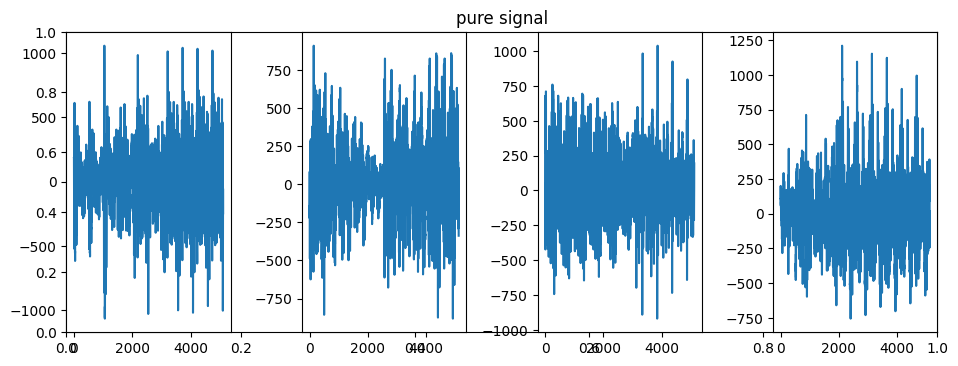

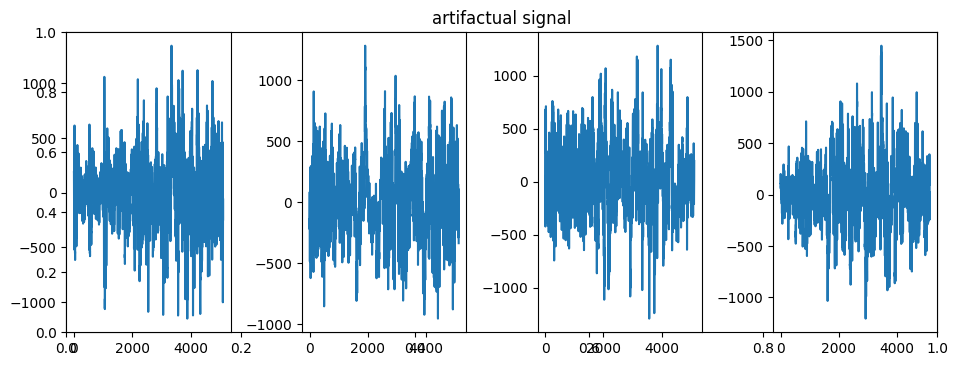

In [7]:
plt.figure(figsize=(10,4))
plt.title("pure signal")
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(pure_EEG_signals[i])
plt.tight_layout()
plt.show() 
    
plt.figure(figsize=(10,4))    
plt.title("artifactual signal")
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(artifactual_EEG_signals[i])  
plt.tight_layout()
plt.show()      

In [8]:
# Normalize signals
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

pure_EEG_signals = normalize(pure_EEG_signals)
artifactual_EEG_signals = normalize(artifactual_EEG_signals)


In [9]:
# Reshape for Conv1D
pure_EEG_signals = pure_EEG_signals[..., np.newaxis]
artifactual_EEG_signals = artifactual_EEG_signals[..., np.newaxis]


In [10]:
print(len(pure_EEG_signals))
print(len(artifactual_EEG_signals))
print(pure_EEG_signals.shape)
print(artifactual_EEG_signals.shape)

450
450
(450, 5120, 1)
(450, 5120, 1)


In [11]:
# Split data
x_train, x_test, y_train, y_test = train_test_split(
    artifactual_EEG_signals, pure_EEG_signals, test_size=0.2, random_state=42
)


In [18]:
print(f"shape of the artifactual signal(x_train): {x_train.shape}")
print(f"shape of the artifactual signal(x_test): {x_test.shape}")

print(f"shape of the pure signal(y_train): {y_train.shape}")
print(f"shape of the pure signal(y_test): {y_test.shape}")


shape of the artifactual signal(x_train): (360, 5120, 1)
shape of the artifactual signal(x_test): (90, 5120, 1)
shape of the pure signal(y_train): (360, 5120, 1)
shape of the pure signal(y_test): (90, 5120, 1)


In [12]:
# Define autoencoder model
def build_autoencoder(input_shape):
    input_layer = Input(shape=input_shape)
    
    # Encoder
    x = Conv1D(32, kernel_size=3, padding="same", activation="relu")(input_layer)
    x = MaxPooling1D(pool_size=2, padding="same")(x)
    x = Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = MaxPooling1D(pool_size=2, padding="same")(x)
    
    # Latent space
    x = Conv1D(128, kernel_size=3, padding="same", activation="relu")(x)
    
    # Decoder
    x = Conv1D(64, kernel_size=3, padding="same", activation="relu")(x)
    x = UpSampling1D(size=2)(x)
    x = Conv1D(32, kernel_size=3, padding="same", activation="relu")(x)
    x = UpSampling1D(size=2)(x)
    
    output_layer = Conv1D(1, kernel_size=3, padding="same", activation="sigmoid")(x)
    
    return Model(input_layer, output_layer)

# Build and compile model
input_shape = x_train.shape[1:]
autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=["mae"])
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5120, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 5120, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2560, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2560, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1280, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 1280, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 1280, 64)       │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d (UpSampling1D)    │ (None, 2560, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 2560, 32)       │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_1 (UpSampling1D)  │ (None, 5120, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5120, 1)        │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,953 (242.00 KB)

 Trainable params: 61,953 (242.00 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train autoencoder
history = autoencoder.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 242ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 0.0013 - val_mae: 0.0265
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 215ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 0.0013 - val_mae: 0.0262
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - loss: 0.0012 - mae: 0.0259 - val_loss: 0.0012 - val_mae: 0.0252
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 406ms/step - loss: 0.0012 - mae: 0.0251 - val_loss: 0.0013 - val_mae: 0.0261
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 437ms/step - loss: 0.0012 - mae: 0.0255 - val_loss: 0.0012 - val_mae: 0.0252
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 387ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 0.0012 - val_mae: 0.0250
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 355ms/step - loss: 0.0011 - mae: 0.0244 - val_loss: 0.0012 - val_mae: 0.0245
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 327ms/step - loss: 0.0011 - mae: 0.0241 - val_loss: 0.0011 - val_mae: 0.0245
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - lo

In [26]:
# Evaluate model
denoised_signals = autoencoder.predict(x_test)

# Compute Signal-to-Noise Ratio (SNR)
def compute_snr(clean, denoised):
    signal_power = np.mean(clean ** 2)
    noise_power = np.mean((clean - denoised) ** 2)
    return 10 * np.log10(signal_power / noise_power)

snr_noisy = compute_snr(y_test.squeeze(), x_test.squeeze())
snr_denoised = compute_snr(y_test.squeeze(), denoised_signals.squeeze())

print(f"SNR of Noisy Signals: {snr_noisy:.2f} dB")
print(f"SNR of Denoised Signals: {snr_denoised:.2f} dB")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
SNR of Noisy Signals: 17.47 dB
SNR of Denoised Signals: 23.77 dB


In [25]:
print(f"length of the denoise signal: {len(denoised_signals)}")
print(f"shape of the denoised signal: {denoised_signals.shape}")

length of the denoise signal: 90
shape of the denoised signal: (90, 5120, 1)


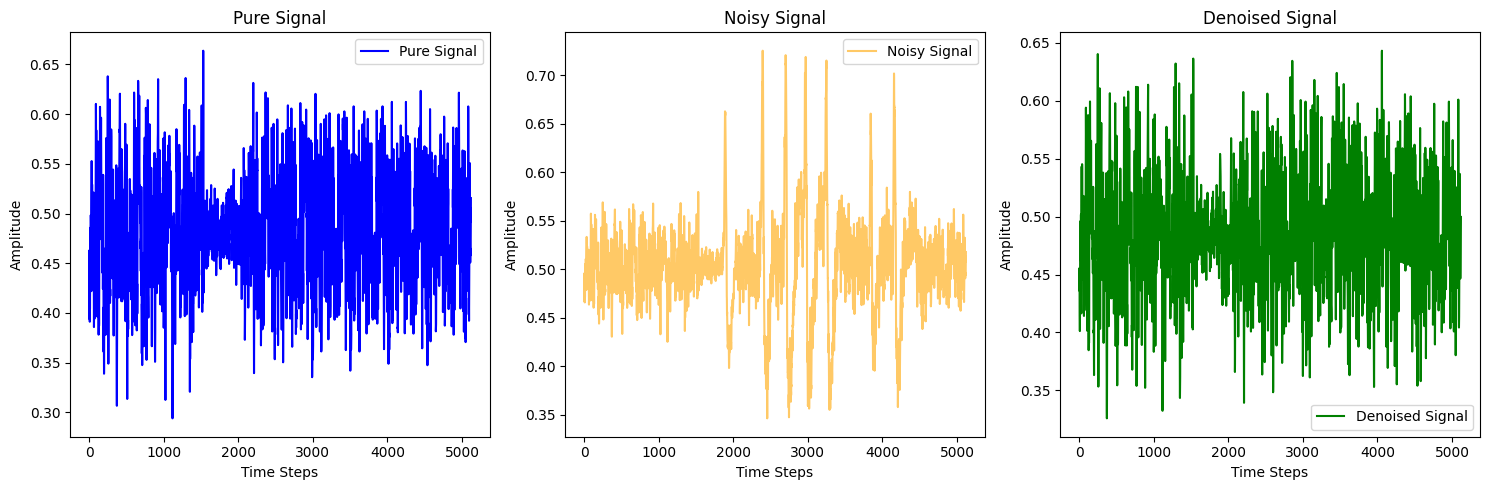

In [27]:
# Visualize results with three subplots
plt.figure(figsize=(15, 5))

# Pure Signal Subplot
plt.subplot(1, 3, 1)
plt.plot(y_test[0].squeeze(), label="Pure Signal", color="blue")
plt.legend()
plt.title("Pure Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")

# Noisy Signal Subplot
plt.subplot(1, 3, 2)
plt.plot(x_test[0].squeeze(), label="Noisy Signal", color="orange", alpha=0.6)
plt.legend()
plt.title("Noisy Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")

# Denoised Signal Subplot
plt.subplot(1, 3, 3)
plt.plot(denoised_signals[0].squeeze(), label="Denoised Signal", color="green")
plt.legend()
plt.title("Denoised Signal")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")

# Show the plots
plt.tight_layout()
plt.show()
